# Spatio-temporal trend analysis of temperature using Python

**Tutors:** Bruno Montibeller<sup>1</sup> and Holger Virro<sup>1</sup>

<sup>1</sup>[**Landscape Geoinformatics Lab**](https://landscape-geoinformatics.ut.ee/home-0), Chair of Geoinformatics, [**Department of Geography**](https://www.geograafia.ut.ee/en), University of Tartu

## Introduction

### Aim of the workshop
The goal of this workshop is to teach the participants how to handle **NetCDF** datasets, apply the [**Mann-Kendall (MK)**](https://www.statisticshowto.com/wp-content/uploads/2016/08/Mann-Kendall-Analysis-1.pdf) test and calculate **Sen's slope (SS)** values on a gridded climate dataset (please, check additional info below).

We will use the gridded daily mean temperature product from **European Climate Assessment and Dataset** (E-OBS version v23.1e) (Cornes et al., 2018). [**E-OBS**](https://surfobs.climate.copernicus.eu/dataaccess/access_eobs.php) is developed by interpolating climate data from weather stations provided by the national meteorological agencies of the European countries. The product is available at a grid resolution of 0.1&deg; or 0.25&deg; and covers the period since 1950 to present. For the workshop, we will use the **0.1&deg; resolution** dataset (which represents a resolution of about 10 km) from **January 2001 until December 2020** already aggregated into **monthly mean temperature (&deg;C)**. The figure below illustrates how we will calculate MK and SS at pixel scale on monthly basis.

<center><img src=https://raw.githubusercontent.com/LandscapeGeoinformatics/EGU_2021_lgeo_workshops/main/SC5.8/trend_calc.png#center width="500"></center>

Under the climate change threat, we need to quantify the spatio-temporal trend of temperature and rainfall patterns to understand and evaluate the potential impacts of climate change on ecosystem services, energy fluxes and biogeochemical processes. There are wide range of global or regional scale climate data freely available in a gridded format that can be used for spatio-temporal analysis. These data can be derived directly from satellite remote sensing data or based on reanalysis of weather station time series data. Additionally, some gridded data are also developed by combining time series data from weather stations with remote sensing data.

### Mann-Kendall test for trend analysis
Different methodologies have combined spatial data sets and nonparametric statistical methods, such as the **Mann-Kendall (MK)** (Mann, 1945; Kendall, 1957) test, to infer about the temporal trends of climatic variables time series (Atta-ur-Rahman and Dawood, 2017; Jaagus et al., 2017; Silva Junior et al., 2018). As MK is a nonparametric test, it does not require normal distribution of the data, but it does assume no autocorrelation in the time series.

The MK test has as null hypothesis that the time series has no trend, and the alternative hypothesis is that it does have a trend (upward or downward). The test first calculates the differences between all pairs of earlier and later data points in the time series. After that, it calculates the variance of these differences, which is posteriorly used to calculate the **Z test** value. Finally, the statistical significance of the trend is quantified by calculating the probability associated with the normalized Z test. If $Z>0$, it indicates an increasing trend and if $Z<0$ it indicates a decreasing trend. Usually, the trends are defined as significant using 95% confidence level. 

In addition to the trend calculation, it is also possible to quantify the magnitude of the trends. The magnitudes can be estimated by using the nonparametric Sen statistic, more specifically, the **Theil&ndash;Sen estimator** (Sen Pranab Kumar, 1968), which is given by the median of the slopes of each pair of points. To calculate the Sen's slope, the times series data is ordered accordingly to the time (as function of time) and a confidence interval is provided for each slope value (same as in the MK test).

### NetCDF files
**NetCDF** is a file format that allows the storage of multidimensional data into a single file archive and has been widely used. Check more info about NetCDF and Python by following this [**YouTube tutorial**](https://youtu.be/K1_8EqCJlwo) produced by [**Copernicus Marine Service**](https://marine.copernicus.eu/).

## Reading the NetCDF file with Xarray

We will start by importing all Python libraries used in this workshop. Data loading will be handled by **[Intake](https://intake.readthedocs.io/en/latest/)**. For data processing and wrangling we are going to use the **[Xarray](http://xarray.pydata.org/en/stable/)**, **[Pandas](https://pandas.pydata.org/)** and **[NumPy](https://numpy.org/)** libraries. **[Matplotlib](https://matplotlib.org/)** will be used for plotting purposes. Trend analysis will be carried out using the **[pyMannKendall](https://pypi.org/project/pymannkendall/)** library.

In [1]:
# Import libraries

# Data loading
import intake
import intake_xarray # Xarray wrapper for Intake
import h5netcdf # for NetCDF reading

# Processing
import xarray as xr
import pandas as pd
import numpy as np
import rioxarray # for CRS management in Xarray

# Trend analysis
import pymannkendall as mk

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import collections
import matplotlib.patches as mpatches
import calendar

Our temperature NetCDF is located in an [ownCloud](https://owncloud.com/) folder and the file's metadata is given in `sc58_catalog.yaml` located in the workshop's GitHub repository.

In [2]:
print('https://raw.githubusercontent.com/LandscapeGeoinformatics/EGU_2021_lgeo_workshops/main/SC5.8/sc58_catalog.yaml')

https://raw.githubusercontent.com/LandscapeGeoinformatics/EGU_2021_lgeo_workshops/main/SC5.8/sc58_catalog.yaml


Let us open the catalog file and list its content. We will use the **[Intake](https://intake.readthedocs.io/en/latest/)** library for loading the data. It allows for convenient data import from external locations.

In [3]:
# Open catalog file
cat = intake.open_catalog('https://raw.githubusercontent.com/LandscapeGeoinformatics/EGU_2021_lgeo_workshops/main/SC5.8/sc58_catalog.yaml')
list(cat)

['monthly_precip_baltics', 'monthly_temp_baltics']

We are going to use only the temperature file named `monthly_temp_baltics.nc` in this workshop. First, let us see the metadata of this NetCDF.

In [4]:
# Read metadata
temp_data = cat.monthly_temp_baltics
temp_data

monthly_temp_baltics:
  args:
    urlpath: https://owncloud.ut.ee/owncloud/index.php/s/EHEWXe5zJSEpaDb/download
  description: Monthly temperature data for the Baltics
  driver: intake_xarray.netcdf.NetCDFSource
  metadata:
    catalog_dir: https://raw.githubusercontent.com/LandscapeGeoinformatics/EGU_2021_lgeo_workshops/main/SC5.8


The metadata includes the parameters
* `urlpath` showing the location of the NetCDF
* the `description` of the data
* `driver` to be used when importing the data
* `catalog_dir` showing the catalog file location

Now we can read the NetCDF with monthly temperature data for the Baltic states in the period 2001&ndash;2020. We are going to read the data as an Xarray dataset. The Xarray library allows for convenient manipulation of multidimensional arrays and interaction with the two main data objects&mdash;DataArray and Dataset&mdash;borrows elements from the Rasterio, Pandas and NumPy Python libraries.

Xarray is a part of the **[Pangeo](https://pangeo.io/index.html)** big data geoscience environment and is particularly useful for working with large datasets. As our dataset is not quite that big, we will only use some of the main Xarray functionalities for our analysis.

As the driver used for reading the file is already specified in the catalog, we can simply use `read` to import the temperature data.

In [5]:
# Import temperature data as an Xarray dataset
temp_ds = temp_data.read()
temp_ds

<xarray.Dataset>
Dimensions:      (latitude: 57, longitude: 72, ym: 240)
Coordinates:
  * latitude     (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude    (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
  * ym           (ym) object '2001-01' '2001-02' ... '2020-11' '2020-12'
    spatial_ref  int32 0
Data variables:
    temp_mean    (latitude, longitude, ym) float32 nan nan nan ... nan nan nan
Attributes:
    grid_mapping:  spatial_ref

Our dataset has three dimensions, each of which has their own set of coordinates. The spatial dimension is made up of 57 `latitude` and 72 `longitude` coordinates, meaning that there are a total of $57\times72=4104$ unique locations with temperature information in the grid. Third dimension `ym` is an array of all 240 year&ndash;month pairs (e.g. 2001-01) covering the 20 year study period.

The fourth coordinate `spatial_ref` is not a separate dimension, but an indicator that a coordinate reference system (CRS) has been assigned to the data. The `grid_mapping` attribute of this fourth coordinate holds information about the CRS of the dataset. If we display the `attrs` property then we can see that the CRS in this case is WGS84.

In [6]:
# Display CRS information
display(temp_ds['spatial_ref'].attrs)

{'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'semi_major_axis': array([6378137.]),
 'semi_minor_axis': array([6356752.31424518]),
 'inverse_flattening': array([298.25722356]),
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': array([0.]),
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'grid_mapping_name': 'latitude_longitude',
 'spatial_ref': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'}

Data variable `temp_mean` contains the monthly temperature amounts of the Baltics in the period 2001&ndash;2020. Since each unique location has a time series length of 240 months, the variable contains a total of $57\times72\times240=984960$ values.

For a quick visualization of our data, let us plot the temperature amount for January 2001. We can use the `sel` function and specify the specific month by using the corresponding coordinate `ym`. We also need to include the data variable `temp_mean` to our plotting call.

In [7]:
# Select a specific month
temp_ds.sel(ym='2001-01')

<xarray.Dataset>
Dimensions:      (latitude: 57, longitude: 72)
Coordinates:
  * latitude     (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude    (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
    ym           <U7 '2001-01'
    spatial_ref  int32 0
Data variables:
    temp_mean    (latitude, longitude) float32 nan nan nan nan ... nan nan nan
Attributes:
    grid_mapping:  spatial_ref

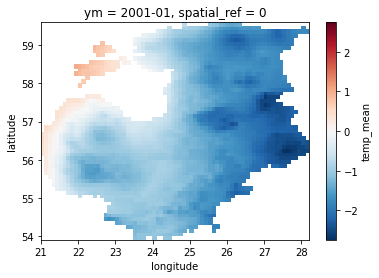

In [8]:
# Select and plot a specific month
temp_ds.sel(ym='2001-01')['temp_mean'].plot()

## Getting data ready for trend analysis

Now that we have familiarized ourselves with the dataset, let us prepare it for trend analysis.

This preprocessing phase will consist of
* Converting the Xarray Dataset into a Pandas DataFrame
* Grouping the data by location (grid cell) and month
* Extracting the grouped temperature values as a NumPy array

We will start by converting the dataset into a Pandas DataFrame using the corresponding function `to_dataframe`. Using `reset_index` will flatten the DataFrame, so that we have a separate row for each of our 984960 monthly temperature records.

In [9]:
# Convert the xarray to Pandas DF
temp_df = temp_ds.to_dataframe().reset_index() # flatten
display(temp_df)

,latitude,longitude,ym,temp_mean,spatial_ref
0,53.949861,21.04986,2001-01,NaN,0
1,53.949861,21.04986,2001-02,NaN,0
2,53.949861,21.04986,2001-03,NaN,0
3,53.949861,21.04986,2001-04,NaN,0
4,53.949861,21.04986,2001-05,NaN,0
...,...,...,...,...,...
984955,59.549861,28.14986,2020-08,NaN,0
984956,59.549861,28.14986,2020-09,NaN,0
984957,59.549861,28.14986,2020-10,NaN,0
984958,59.549861,28.14986,2020-11,NaN,0


The input data includes a large number of missing values, indicated by `NaN` in the `temp_mean` column. These are grid cells located outside the study area (i.e. the Baltic Sea, neighboring countries).

We should remove them with `dropna` before moving on.

In [10]:
# Drop rows with missing temperature values
temp_df = temp_df.dropna().reset_index()
temp_df

,index,latitude,longitude,ym,temp_mean,spatial_ref
0,6000,53.949861,23.54986,2001-01,-1.155484,0
1,6001,53.949861,23.54986,2001-02,-2.777500,0
2,6002,53.949861,23.54986,2001-03,0.088065,0
3,6003,53.949861,23.54986,2001-04,8.223666,0
4,6004,53.949861,23.54986,2001-05,13.019676,0
...,...,...,...,...,...,...
611275,980635,59.549861,26.34986,2020-08,16.812258,0
611276,980636,59.549861,26.34986,2020-09,13.711668,0
611277,980637,59.549861,26.34986,2020-10,9.299999,0
611278,980638,59.549861,26.34986,2020-11,5.165666,0


Let us also split the `ym` column into separate `year` and `month` columns for more convenient grouping later on. We can use the function `split` for that and specify the delimiter in the original column.

In [11]:
# Extract year and month from the observation date as new columns
temp_df[['year', 'month']] = temp_df['ym'].str.split('-', expand=True) # expand=True tells Pandas that there are two output columns
temp_df['year'] = temp_df['year'].astype(int) # astype(int) will convert string column into integer
temp_df['month'] = temp_df['month'].astype(int)
display(temp_df)

,index,latitude,longitude,ym,temp_mean,spatial_ref,year,month
0,6000,53.949861,23.54986,2001-01,-1.155484,0,2001,1
1,6001,53.949861,23.54986,2001-02,-2.777500,0,2001,2
2,6002,53.949861,23.54986,2001-03,0.088065,0,2001,3
3,6003,53.949861,23.54986,2001-04,8.223666,0,2001,4
4,6004,53.949861,23.54986,2001-05,13.019676,0,2001,5
...,...,...,...,...,...,...,...,...
611275,980635,59.549861,26.34986,2020-08,16.812258,0,2020,8
611276,980636,59.549861,26.34986,2020-09,13.711668,0,2020,9
611277,980637,59.549861,26.34986,2020-10,9.299999,0,2020,10
611278,980638,59.549861,26.34986,2020-11,5.165666,0,2020,11


In order to make sure that the monthly temperature values end up in the correct order during grouping we should sort the DataFrame by year and month. This can be done using the `sort_values` function.

In [12]:
# Sort the DataFrame by year and month in ascending order
temp_df.sort_values(['year', 'month'], ascending=[True, True], inplace=True) # inplace=True tells Pandas to modify the existing object

Now we can aggregate the DataFrame by location and month. We will use `groupby` to determine the columns used for grouping and assign `temp_mean` as the target column.

Pandas function `apply` can be used for applying different functions rowwise in a DataFrame. In this case, we use parameter `np.array` to tell `apply` to collect the grouped temperature values into a NumPy array for each row.

In [13]:
# Group locations by month and collect observation values to NumPy array
temp_group_df = temp_df\
    .groupby(['latitude', 'longitude', 'month'])['temp_mean']\
    .apply(np.array)\
    .reset_index() # flatten the DataFrame
display(temp_group_df)

,latitude,longitude,month,temp_mean
0,53.949861,23.54986,1,"[-1.155484, -1.569032, -5.0525813, -6.9348392,..."
1,53.949861,23.54986,2,"[-2.7775, 2.2021434, -6.039285, -1.8844824, -5..."
2,53.949861,23.54986,3,"[0.08806454, 3.3738706, 0.8622579, 1.8580645, ..."
3,53.949861,23.54986,4,"[8.223666, 8.266, 5.5366664, 7.551, 7.8069997,..."
4,53.949861,23.54986,5,"[13.019676, 15.822902, 14.108708, 10.822258, 1..."
...,...,...,...,...
30559,59.549861,26.34986,8,"[15.805161, 18.406773, 16.10516, 17.048388, 16..."
30560,59.549861,26.34986,9,"[12.335667, 11.58, 11.987667, 12.545667, 13.21..."
30561,59.549861,26.34986,10,"[8.4554825, 1.8396775, 4.703548, 6.5590324, 7...."
30562,59.549861,26.34986,11,"[0.766, -1.2219999, 2.9746668, 0.9679999, 3.94..."


Let us check the cell content in the array column for the first row. It contains 20 years worth of monthly temperature mean values for January at 53.9499 latitude and 23.5499 longitude.

We can use `iloc` to select a DataFrame row by index.

In [14]:
# Display first row
display(temp_group_df.iloc[0])

# Display cell content in the grouped column
display(temp_group_df.iloc[0]['temp_mean'])

latitude                                               53.9499
longitude                                              23.5499
month                                                        1
temp_mean    [-1.155484, -1.569032, -5.0525813, -6.9348392,...
Name: 0, dtype: object

array([ -1.155484  ,  -1.569032  ,  -5.0525813 ,  -6.9348392 ,
        -0.04483882,  -7.9774194 ,   1.5177417 ,  -0.8593547 ,
        -3.7196774 , -10.487097  ,  -2.7848382 ,  -3.04      ,
        -5.996774  ,  -5.3016133 ,  -0.33290324,  -5.7196774 ,
        -4.384839  ,  -1.638387  ,  -4.256451  ,   2.0070968 ],
      dtype=float32)

## Trend analysis using the Mann-Kendall (MK) test

Now we have the temperature arrays in a column and can move on with the trend analysis. We are going to use the [**pyMannKendall**](https://pypi.org/project/pymannkendall/) library for that.

Although there are 13 different versions of the MK test available in pyMannKendall, the `original_test` will suffice for now.

The test will return a tuple containing the named parameters
* **trend:** tells the trend (increasing, decreasing or no trend)
* **h:** True (if trend is present) or False (if the trend is absence)
* **p:** p-value of the significance test
* **z:** normalized test statistics
* **Tau:** Kendall Tau
* **s:** Mann-Kendal's score
* **var_s:** Variance S
* **slope:** Theil-Sen estimator/slope
* **intercept:** intercept of Kendall-Theil Robust Line

In [15]:
# Check the ouput of the MK test function
array = temp_group_df.iloc[0]['temp_mean']
result = mk.original_test(array, alpha=0.05)
display(result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.9741177473553713, z=0.03244428422615251, Tau=0.010526315789473684, s=2.0, var_s=950.0, slope=0.03997344138858082, intercept=-3.759586398254384)

We will loop over the arrays in the `temp_mean` column, applying the MK test each time using `apply`. Confidence level&mdash;0.05 in our case&mdash;can be assigned with parameter `alpha`.

This can take some time as we need to repeat the process as many times as there are rows, i.e. **30564** iterations in total.

In [16]:
%%time
# Apply MK test rowwise and collect result into new column
temp_group_df['result'] = temp_group_df['temp_mean'].apply(lambda x: mk.original_test(x, alpha=0.05))
display(temp_group_df)

,latitude,longitude,month,temp_mean,result
0,53.949861,23.54986,1,"[-1.155484, -1.569032, -5.0525813, -6.9348392,...","(no trend, False, 0.9741177473553713, 0.032444..."
1,53.949861,23.54986,2,"[-2.7775, 2.2021434, -6.039285, -1.8844824, -5...","(no trend, False, 0.2299690777236405, 1.200438..."
2,53.949861,23.54986,3,"[0.08806454, 3.3738706, 0.8622579, 1.8580645, ...","(no trend, False, 0.2299690777236405, 1.200438..."
3,53.949861,23.54986,4,"[8.223666, 8.266, 5.5366664, 7.551, 7.8069997,...","(no trend, False, 0.7702877264736667, 0.291998..."
4,53.949861,23.54986,5,"[13.019676, 15.822902, 14.108708, 10.822258, 1...","(no trend, False, 0.9741177473553713, 0.032444..."
...,...,...,...,...,...
30559,59.549861,26.34986,8,"[15.805161, 18.406773, 16.10516, 17.048388, 16...","(no trend, False, 0.721176307474874, 0.3568871..."
30560,59.549861,26.34986,9,"[12.335667, 11.58, 11.987667, 12.545667, 13.21...","(no trend, False, 0.07435290536856365, 1.78443..."
30561,59.549861,26.34986,10,"[8.4554825, 1.8396775, 4.703548, 6.5590324, 7....","(no trend, False, 0.5376032363488861, 0.616441..."
30562,59.549861,26.34986,11,"[0.766, -1.2219999, 2.9746668, 0.9679999, 3.94...","(no trend, False, 0.07435290536856365, 1.78443..."


Wall time: 36.1 s


For our purposes, we will only extract parameters `trend`, `p` and `slope`, which have the indices **0**, **2** and **7**, respectively. We can use these indices to extract the parameters into separate columns from the MK test `result` column.

In [17]:
temp_group_df['trend'] = temp_group_df['result'].apply(lambda x: x[0])
temp_group_df['p'] = temp_group_df['result'].apply(lambda x: x[2])
temp_group_df['slope'] = temp_group_df['result'].apply(lambda x: x[7])
temp_group_df

,latitude,longitude,month,temp_mean,result,trend,p,slope
0,53.949861,23.54986,1,"[-1.155484, -1.569032, -5.0525813, -6.9348392,...","(no trend, False, 0.9741177473553713, 0.032444...",no trend,0.974118,0.039973
1,53.949861,23.54986,2,"[-2.7775, 2.2021434, -6.039285, -1.8844824, -5...","(no trend, False, 0.2299690777236405, 1.200438...",no trend,0.229969,0.251141
2,53.949861,23.54986,3,"[0.08806454, 3.3738706, 0.8622579, 1.8580645, ...","(no trend, False, 0.2299690777236405, 1.200438...",no trend,0.229969,0.135081
3,53.949861,23.54986,4,"[8.223666, 8.266, 5.5366664, 7.551, 7.8069997,...","(no trend, False, 0.7702877264736667, 0.291998...",no trend,0.770288,0.012048
4,53.949861,23.54986,5,"[13.019676, 15.822902, 14.108708, 10.822258, 1...","(no trend, False, 0.9741177473553713, 0.032444...",no trend,0.974118,0.000922
...,...,...,...,...,...,...,...,...
30559,59.549861,26.34986,8,"[15.805161, 18.406773, 16.10516, 17.048388, 16...","(no trend, False, 0.721176307474874, 0.3568871...",no trend,0.721176,0.018852
30560,59.549861,26.34986,9,"[12.335667, 11.58, 11.987667, 12.545667, 13.21...","(no trend, False, 0.07435290536856365, 1.78443...",no trend,0.074353,0.066889
30561,59.549861,26.34986,10,"[8.4554825, 1.8396775, 4.703548, 6.5590324, 7....","(no trend, False, 0.5376032363488861, 0.616441...",no trend,0.537603,0.042174
30562,59.549861,26.34986,11,"[0.766, -1.2219999, 2.9746668, 0.9679999, 3.94...","(no trend, False, 0.07435290536856365, 1.78443...",no trend,0.074353,0.129285


We can use Pandas function `value_counts` to display how many grid cells ended up in each of the trend classes. We will do this for each month, so we are going to group `temp_group_df` again by month and loop through it.

In [18]:
# Loop through months and display significant trend count
for month, df in temp_group_df.groupby('month'):
    print('Siginificant trends in month number ' + str(month))
    display(df['trend'].value_counts())
    print('\n')

Siginificant trends in month number 1


no trend    2547
Name: trend, dtype: int64



Siginificant trends in month number 2


no trend    2547
Name: trend, dtype: int64



Siginificant trends in month number 3


no trend    2547
Name: trend, dtype: int64



Siginificant trends in month number 4


no trend      2536
increasing      11
Name: trend, dtype: int64



Siginificant trends in month number 5


no trend    2547
Name: trend, dtype: int64



Siginificant trends in month number 6


no trend      1531
increasing    1016
Name: trend, dtype: int64



Siginificant trends in month number 7


no trend      2436
decreasing     111
Name: trend, dtype: int64



Siginificant trends in month number 8


no trend    2547
Name: trend, dtype: int64



Siginificant trends in month number 9


no trend      1589
increasing     958
Name: trend, dtype: int64



Siginificant trends in month number 10


no trend      2469
increasing      78
Name: trend, dtype: int64



Siginificant trends in month number 11


increasing    2067
no trend       480
Name: trend, dtype: int64



Siginificant trends in month number 12


no trend      2543
increasing       4
Name: trend, dtype: int64

We can see that a large majority of locations did not show a significant trend during the study period as most cells indicated no trend.

Next we will convert the parameter `trend` into a new numeric column, which is required for plotting later on.

Let us first create a function that assigns a new numeric trend class based on `p` and `slope`. Negative significant trends will be indicated by **-1**, positive trends by **1** and **0** will be assigned to locations where no trend was detected.

In [19]:
# Function for numeric trend conversion
def numeric_trend(slope, p):
    if slope < 0 and p < 0.05:
        return -1
    elif slope > 0 and p < 0.05:
        return 1
    else:
        return 0

Now we can use `apply` and its `lambda` parameter to generate the `numeric_trend` column. The `lambda` parameter is useful for applying a function to each row.

In our case, we are taking the values of columns `slope` and `p` for each row as input parameters for our function `numeric_trend`, which we created in the last step. Parameter `axis=1` will tell the function that we are iterating over rows rather than columns.

Some examples of `lambda` use can be found at [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html).

In [20]:
# Create a numeric version of the trend column
temp_group_df['numeric_trend'] = temp_group_df.apply(lambda x: numeric_trend(x['slope'], x['p']), axis=1)
display(temp_group_df)

,latitude,longitude,month,temp_mean,result,trend,p,slope,numeric_trend
0,53.949861,23.54986,1,"[-1.155484, -1.569032, -5.0525813, -6.9348392,...","(no trend, False, 0.9741177473553713, 0.032444...",no trend,0.974118,0.039973,0
1,53.949861,23.54986,2,"[-2.7775, 2.2021434, -6.039285, -1.8844824, -5...","(no trend, False, 0.2299690777236405, 1.200438...",no trend,0.229969,0.251141,0
2,53.949861,23.54986,3,"[0.08806454, 3.3738706, 0.8622579, 1.8580645, ...","(no trend, False, 0.2299690777236405, 1.200438...",no trend,0.229969,0.135081,0
3,53.949861,23.54986,4,"[8.223666, 8.266, 5.5366664, 7.551, 7.8069997,...","(no trend, False, 0.7702877264736667, 0.291998...",no trend,0.770288,0.012048,0
4,53.949861,23.54986,5,"[13.019676, 15.822902, 14.108708, 10.822258, 1...","(no trend, False, 0.9741177473553713, 0.032444...",no trend,0.974118,0.000922,0
...,...,...,...,...,...,...,...,...,...
30559,59.549861,26.34986,8,"[15.805161, 18.406773, 16.10516, 17.048388, 16...","(no trend, False, 0.721176307474874, 0.3568871...",no trend,0.721176,0.018852,0
30560,59.549861,26.34986,9,"[12.335667, 11.58, 11.987667, 12.545667, 13.21...","(no trend, False, 0.07435290536856365, 1.78443...",no trend,0.074353,0.066889,0
30561,59.549861,26.34986,10,"[8.4554825, 1.8396775, 4.703548, 6.5590324, 7....","(no trend, False, 0.5376032363488861, 0.616441...",no trend,0.537603,0.042174,0
30562,59.549861,26.34986,11,"[0.766, -1.2219999, 2.9746668, 0.9679999, 3.94...","(no trend, False, 0.07435290536856365, 1.78443...",no trend,0.074353,0.129285,0


Before plotting the trend results we need to convert our DataFrame back into an Xarray dataset. This can be done with `to_xarray`, but first we need to use `set_index` and assign an index to the DataFrame. The columns used for the index will end up as dimensions in the resulting Xarray dataset.

Let us also assign a CRS with `write_crs` from [**rioxarray**](https://corteva.github.io/rioxarray/stable/), which is a supplementary Xarray library used for spatial operations.

In [21]:
# Convert the DataFrame back to xarray Dataset and assign CRS
temp_group_df.set_index(['latitude', 'longitude', 'month'], inplace=True)
temp_array = temp_group_df.to_xarray()
temp_array.rio.write_crs('epsg:4326', inplace=True)
display(temp_array)

<xarray.Dataset>
Dimensions:        (latitude: 57, longitude: 72, month: 12)
Coordinates:
  * latitude       (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude      (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref    int32 0
Data variables:
    temp_mean      (latitude, longitude, month) object nan nan nan ... nan nan
    result         (latitude, longitude, month) object nan nan nan ... nan nan
    trend          (latitude, longitude, month) object nan nan nan ... nan nan
    p              (latitude, longitude, month) float64 nan nan nan ... nan nan
    slope          (latitude, longitude, month) float64 nan nan nan ... nan nan
    numeric_trend  (latitude, longitude, month) float64 nan nan nan ... nan nan
Attributes:
    grid_mapping:  spatial_ref

## Plotting the trend analysis results

### Plotting slopes

Finally, we can plot our results.

First, let us take a look at the spatial and temporal pattern of the `slope` parameter. This will give an idea where and when temperature has changed the most. The change will be represented in &deg;C/year.

Before plotting, let us create a list of months for the iteration.

In [22]:
# List of months used for iterating
months = temp_array['month']
display(months)

<xarray.DataArray 'month' (month: 12)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)
Coordinates:
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref  int32 0

For plotting monthly slope values indicating the intensity of temperature change, we will create a Matplotlib figure object `fig` consisting of a $4\times3$ grid of axes.

While iterating over each of the 12 months and their corresponding axes we
* will select the corresponding dataset slice from `temp_array` using the `sel` command
* plot the slope values for that particular month
* have a colorbar next to the subplots showing the magnitude of temperature change

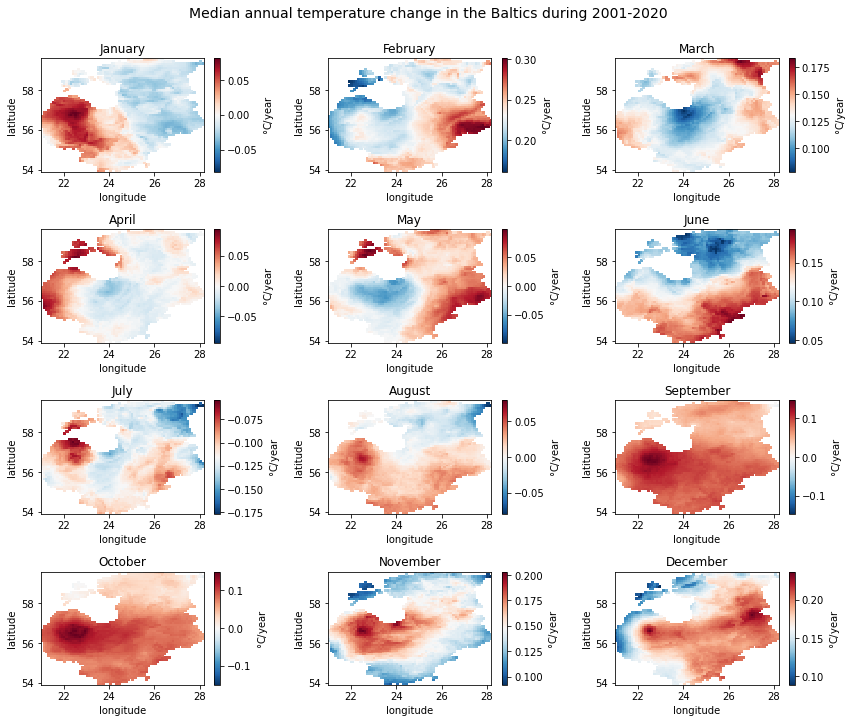

In [35]:
# Degree symbol for colorbar
degree_symbol = '$\degree$'

# Create figure and iterate over months to plot slope values in cells
fig, axes = plt.subplots(4, 3, figsize=(12, 10))
for month, ax in zip(months, axes.flatten()):
    ds = temp_array.sel(month=month) # select the month
    ds['slope'].plot(ax=ax, cmap='RdBu_r', cbar_kwargs={'label': '{}C/year'.format(degree_symbol)}) # plot slope values
    month_name = calendar.month_name[int(month)] # get month name
    ax.set_title(month_name)

# Add the title
fig_title = 'Median annual temperature change in the Baltics during 2001-2020'
fig.suptitle(fig_title, y=1, size=14)

# Reduce whitespace around the plot
fig.tight_layout()

For setting the range of the colorbar, we need to know the full range of slope values in the data by checking the minimum and maximum values.

In [36]:
display(temp_array['slope'].min())
display(temp_array['slope'].max())

<xarray.DataArray 'slope' ()>
array(-0.17666797)
Coordinates:
    spatial_ref  int32 0

<xarray.DataArray 'slope' ()>
array(0.30160443)
Coordinates:
    spatial_ref  int32 0

We will create a colorbar normalization object called `divnorm` to set the range. Using the `TwoSlopeNorm` command and setting the parameters `vmin=-0.2` and `vmax=0.4` should cover the range of slope values. As our colorbar is diverging, we also need to set `vcenter=0`.

In [37]:
divnorm = mcolors.TwoSlopeNorm(vmin=-0.2, vcenter=0, vmax=0.4)

We can now recreate the plot with our custom colorbar range by specifying the `norm` parameter.

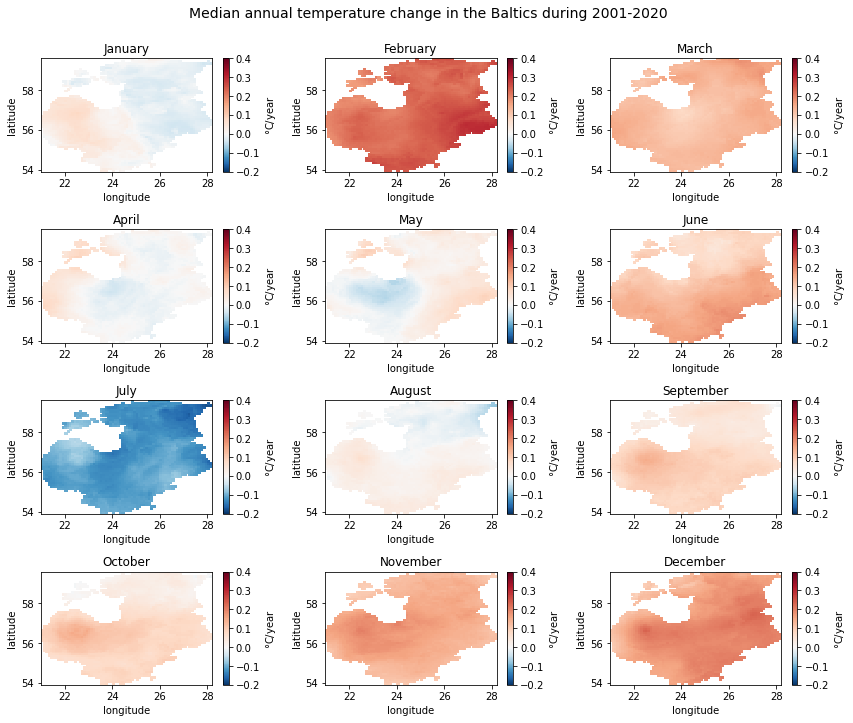

In [39]:
# Degree symbol for colorbar
degree_symbol = '$\degree$'

# Create figure and iterate over months to plot slope values in cells
fig, axes = plt.subplots(4, 3, figsize=(12, 10))
for month, ax in zip(months, axes.flatten()):
    ds = temp_array.sel(month=month) # select the month
    ds['slope'].plot(ax=ax, cmap='RdBu_r', norm=divnorm, cbar_kwargs={'label': '{}C/year'.format(degree_symbol)}) # plot slope values with custom colorbar range
    month_name = calendar.month_name[int(month)] # get month name
    ax.set_title(month_name)

# Add the title
fig_title = 'Median annual temperature change in the Baltics during 2001-2020'
fig.suptitle(fig_title, y=1, size=14)

# Reduce whitespace around the plot
fig.tight_layout()

From the plots we can see that majority of the months show an increasing trend, which is the strongest in February and December. Although parts of the Baltics show a slight decreasing trend in other months (e.g. the western part in January), the only month with a clear decreasing trend is July. No clear spatial pattern exists in the detected significant trend locations.

### Plotting significant trends

As we examined above when printing out detected significant trend counts per month, only some grid cells indicated significant trends in the study period. We could also see that the three possible trend classes&mdash;decreasing, no trend and increasing&mdash; are not present in the case of some months.

To see whether the temperature changes seen in the previous plot were also statistically significant, we will now plot the `numeric_trend` variable. We will use the three numeric trend classes to set the colorbar. To avoid getting unnecessary ticks in the colorbar, we need to specify the corresponding parameter in `cbar_kwargs`.

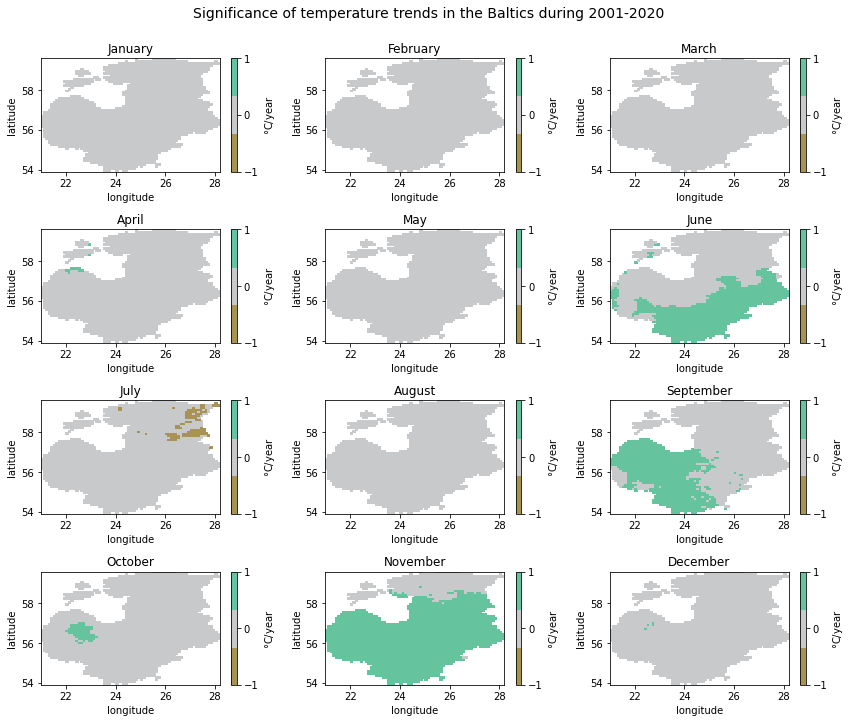

In [42]:
# Set colorbar range
divnorm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

# Colormap
colors = ['#A89355', '#C8C9CA', '#65C39E']
cmap = matplotlib.colors.ListedColormap(colors)

# Create figure and iterate over months to plot significance of trends in cells
fig, axes = plt.subplots(4, 3, figsize=(12, 10))
for month, ax in zip(months, axes.flatten()):
    ds = temp_array.sel(month=month) # select month
    ds['numeric_trend'].plot(ax=ax, norm=divnorm, cmap=cmap, cbar_kwargs={'ticks': [-1, 0, 1], 'label': '{}C/year'.format(degree_symbol)}) # plot trends
    month_name = calendar.month_name[int(month)] # get month name
    ax.set_title(month_name)

# Add the title
fig_title = 'Significance of temperature trends in the Baltics during 2001-2020'
fig.suptitle(fig_title, y=1, size=14)

# Reduce whitespace around the plot
fig.tight_layout()

Although there is no clear temporal or spatial pattern in the significant trends detected, we can see that increasing trends were mostly present in the southern half of the study area, i.e. Latvia and Lithuania. In November, significant increasing trends also reached southern Estonia. The only significant decreasing trends were detected in July, particularly in the eastern part of Estonia.

Perhaps somewhat surprisingly, the winter months with the highest slope values&mdash;February and December&mdash; did not show up as significant trends.

### Automatic plotting

We have now learned to plot the hard way by customizing the figures manually. Xarray and Matplotlib can actually do certain things for us when plotting, so that quick plots can be displayed with a single line of code.

For this, we use the `imshow` command and specify the coordinates with `longitude` and `latitude`. The `col` parameter make sure that we get a plot for each month. Parameter `col_wrap` tells Matplotlib to plot three months per row.

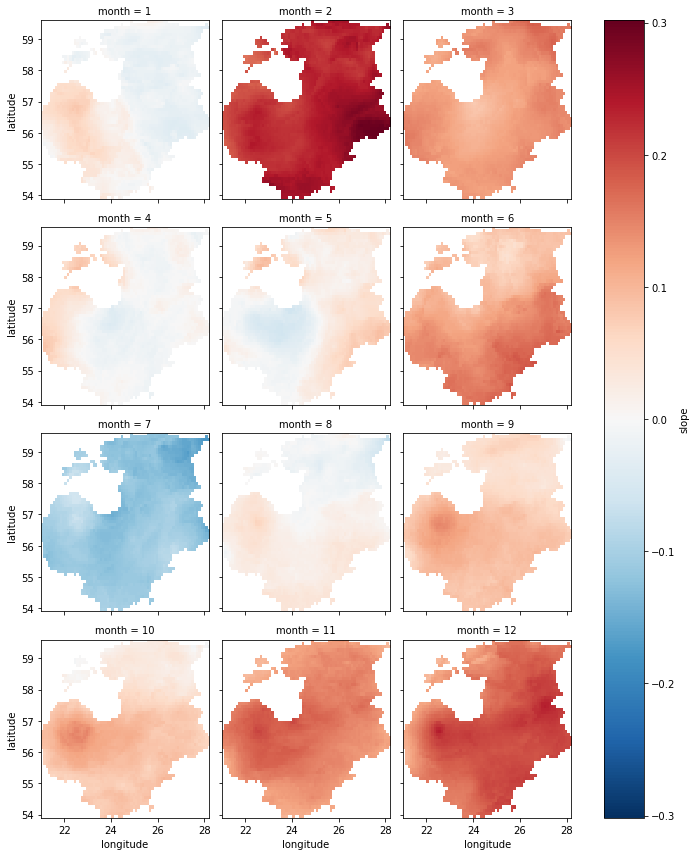

In [34]:
# Plot monthly slope values automatically
temp_array['slope'].plot.imshow('longitude', 'latitude', col='month', col_wrap=3)

## References

* Atta-ur-Rahman, and Dawood, M. (2017). Spatio-statistical analysis of temperature fluctuation using Mann–Kendall and Sen’s slope approach. Clim. Dyn. 48, 783–797. doi:10.1007/s00382-016-3110-y.

* Cornes, R. C., van der Schrier, G., van den Besselaar, E. J. M., and Jones, P. D. (2018). An Ensemble Version of the E-OBS Temperature and temperature Data Sets. J. Geophys. Res. Atmos. 123, 9391–9409. doi:10.1029/2017JD028200.

* Jaagus, J., Sepp, M., Tamm, T., Järvet, A., and Mõisja, K. (2017). Trends and regime shifts in climatic conditions and river runoff in Estonia during 1951–2015. Earth Syst. Dyn. 8, 963–976. doi:10.5194/esd-8-963-2017.

* Kendall, M. G. (1957). Rank Correlation Methods. Biometrika 44, 298. doi:10.2307/2333282.

* Mann, H. B. (1945). Non-Parametric Test Against Trend. Econometrica 13, 245–259. Available at: http://www.economist.com/node/18330371?story%7B_%7Did=18330371.

* Sen Pranab Kumar (1968). Estimates of the Regression Coefficient Based on Kendall’s Tau. J. Am. Stat. Assoc. 63, 1379–1389.

* Silva Junior, C. H. L., Almeida, C. T., Santos, J. R. N., Anderson, L. O., Aragão, L. E. O. C., and Silva, F. B. (2018). Spatiotemporal rainfall trends in the Brazilian legal Amazon between the years 1998 and 2015. Water (Switzerland) 10, 1–16. doi:10.3390/w10091220.